In [1]:
# Import 
import os
import time
import json
import random
import datetime
import numpy as np
import pandas as pd

from IPython.display import display

from pathlib import Path

from tyssue import config
from tyssue import Sheet

from tyssue.io import hdf5
from tyssue.io.hdf5 import load_datasets

from tyssue.dynamics import SheetModel as basemodel
from tyssue.dynamics import units, effectors, model_factory

from tyssue.solvers.quasistatic import QSSolver
from tyssue.solvers.viscous import EulerSolver

from tyssue.draw import sheet_view
from tyssue.draw import highlight_faces, create_gif
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.ipv_draw import sheet_view as ipv_draw 

from tyssue.behaviors.event_manager import EventManager
from tyssue.behaviors.sheet import actions, basic_events
from tyssue.behaviors.sheet.apoptosis_events import apoptosis


from tyssue import config, Sheet, PlanarGeometry
from tyssue.dynamics import effectors, model_factory
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.utils import data_at_opposite
from tyssue.solvers import QSSolver


import matplotlib.pyplot as plt
%matplotlib inline

try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')


In [2]:

from polarity.dynamics import EllipsoidLameGeometry as geom

from polarity.apoptosis import apoptosis

from polarity.toolbox import (init,
                              define_fold_position,
                              apoptosis_ventral,
                              apoptosis_lateral,
                              apoptosis_dorsal,
                             )

In [3]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/202003-testprotein')

sim_save_dir = SIM_DIR

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [4]:
model = model_factory(
    [
        effectors.RadialTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)

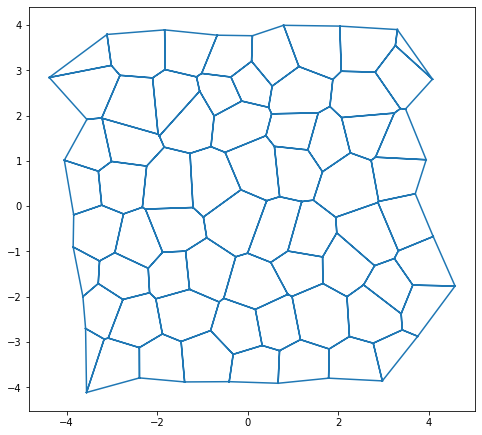

In [5]:
from scipy.spatial import Voronoi
from tyssue.config.geometry import planar_spec
from tyssue.generation import hexa_grid2d, from_2d_voronoi

# init tissue
grid = hexa_grid2d(10, 10, 1, 1, noise=0.2)
datasets = from_2d_voronoi(Voronoi(grid))

#propriété du df de prot
spec_prot={'x':0.0,
          'y':0.0,
          'z':0.0,
          'name':'name',
          'face':0,
          'edge':0,
          'coeff_diffusion':0.0,
          'bind_width':0.0,
          'bind_rate':0.0,
          'unbind_rate':0.0}

index = ['x', 'y', 'z', 'name', 'face', 'edge', 
         'coeff_diffusion', 'bind_width', 'bind_rate', 'unbind_rate']
dtypes = np.dtype([(name, type(val)) for name, val in spec_prot.items()])
N = len(index)
arr = np.empty(N, dtype=dtypes)
prot_df = pd.DataFrame.from_records(arr, index=index)
datasets['prot'] = prot_df
sheet = Sheet('jam', datasets, specs=planar_spec(), coords= ['x', 'y'])

PlanarGeometry.update_all(sheet)
solver = QSSolver(with_t1=False, with_collisions=False)


sheet.remove(sheet.cut_out([[0, 10], [0, 10]]))
sheet.sanitize(trim_borders=True)
PlanarGeometry.scale(sheet, sheet.face_df.area.mean()**-0.5, ['x', 'y'])
PlanarGeometry.center(sheet)
PlanarGeometry.update_all(sheet)
sheet.reset_index()
sheet.reset_topo()

fig, ax = sheet_view(sheet, mode='quick',)
fig.set_size_inches((8, 8))

In [125]:
class Protein():
    def __init__(self, specs):
        self.specs = specs
        self.prot_df = pd.DataFrame(columns=['name', 'x', 'y', 'z', 'face', 'edge'])

            
        
class SheetProtein():
    def __init__(self, sheet, specs_prot):
        
        self.sheet = sheet
        
        self.specs_prot = specs_prot
        
        nb_prot_tot = 0
        name = np.empty(0)
        for k in specs_prot.keys():
            nb_prot_tot += specs_prot[k]['nb_prot']
#             name = np.concatenate(name, 
#                                   np.repeat(k, 
#                                             specs_prot[k]['nb_prot']))
                        
                        
                        
        #Peut etre qu'il va falloir le créer à la toute fin... 
        #plutôt que de le completer au fur et à mesure...
        self.prot_df = pd.DataFrame(data = np.zeros((nb_prot_tot*sheet.Nf, 7)), 
                                    columns=['name', 'x', 'y', 'z', 'face', 'edge', 'diffusion_dt'])
        
        for k in specs_prot.keys():
            for f in range (sheet.Nf):
                start = f*specs_prot[k]['nb_prot']
                end = start+specs_prot[k]['nb_prot']
                
                self.prot_df.loc[start:end, 'name'] = k
                self.prot_df.loc[start:end, 'face'] = f
                self.prot_df.loc[start:end, 'edge'] = -1
                
                # Following the formula : diffusion_dt = sqrt(6*coef_diffusion*dt)
                self.prot_df.loc[start:end, 'diffusion_dt'] = np.sqrt(
                    6*specs_prot[k]['coeff_diffusion']*self.sheet.specs['dt'])
                
                # Les protéines sont placés au centre de la face
                self.prot_df.loc[start:end, 'x'] = self.sheet.face_df.loc[f]['x']
                self.prot_df.loc[start:end, 'y'] = self.sheet.face_df.loc[f]['y']
                if 'z' in self.sheet.face_df.columns:
                    self.prot_df.loc[start:end, 'z'] = self.sheet.face_df.loc[f]['z']
                                  

            
            
    def diffusion(self):
        """
        Diffusion of protein follow the formula : 
        x_t+1 = x_t + diffusion_dt * rand(-1,1)
        y_t+1 = y_t + diffusion_dt * rand(-1,1)
        z_t+1 = z_t + diffusion_dt * rand(-1,1)
        """
        self.prot_df['x'] += self.prot_df['diffusion_dt']*np.random.uniform(-1,1, sheetprot.prot_df.shape[0])
        self.prot_df['y'] += self.prot_df['diffusion_dt']*np.random.uniform(-1,1, sheetprot.prot_df.shape[0])
        if 'z' in self.sheet.face_df.columns:
            self.prot_df['z'] += self.prot_df['diffusion_dt']*np.random.uniform(-1,1, sheetprot.prot_df.shape[0])
        
        
        

In [126]:
sheet.specs['dt'] = 0.1
prot_specs = {"myosin":
              {
              "coeff_diffusion":0.1,
              "binding_rate":0.5,
              "unbingind_rate":0.2,
              "binding_range":0.5,
              "nb_prot":10}}

sheetprot = SheetProtein(sheet, prot_specs)
sheetprot.prot_df.loc[0:100:5]

,name,x,y,z,face,edge,diffusion_dt
0,myosin,-3.437238,-3.248904,0.0,0.0,-1.0,0.244949
5,myosin,-3.437238,-3.248904,0.0,0.0,-1.0,0.244949
10,myosin,-2.919649,-3.374385,0.0,1.0,-1.0,0.244949
15,myosin,-2.919649,-3.374385,0.0,1.0,-1.0,0.244949
20,myosin,-1.907899,-3.320254,0.0,2.0,-1.0,0.244949
25,myosin,-1.907899,-3.320254,0.0,2.0,-1.0,0.244949
30,myosin,-0.884671,-3.351488,0.0,3.0,-1.0,0.244949
35,myosin,-0.884671,-3.351488,0.0,3.0,-1.0,0.244949
40,myosin,0.190408,-3.463647,0.0,4.0,-1.0,0.244949
45,myosin,0.190408,-3.463647,0.0,4.0,-1.0,0.244949


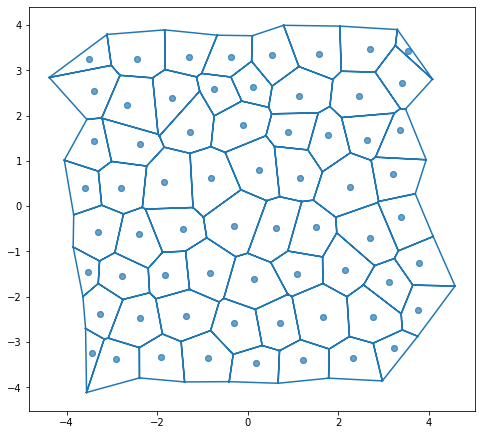

In [127]:
fig, ax = sheet_view(sheetprot.sheet, mode='quick',)
ax.scatter(sheetprot.prot_df.x, sheetprot.prot_df.y, alpha = 0.1)
fig.set_size_inches((8, 8))

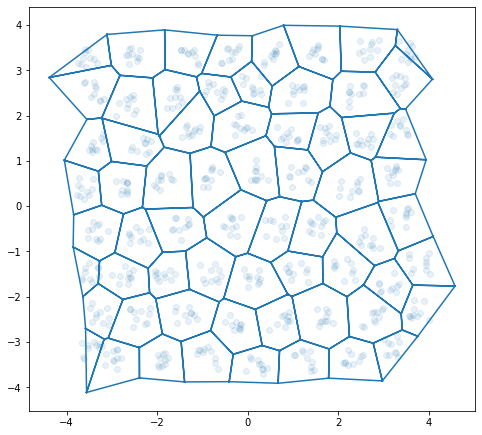

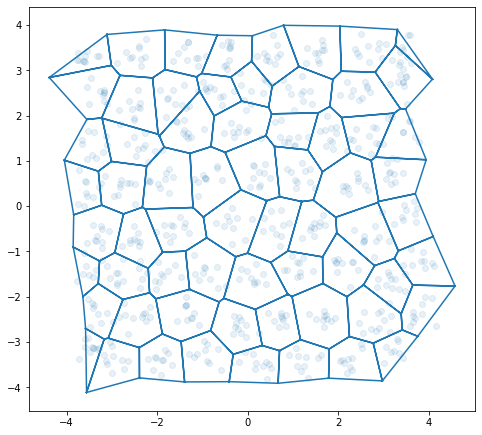

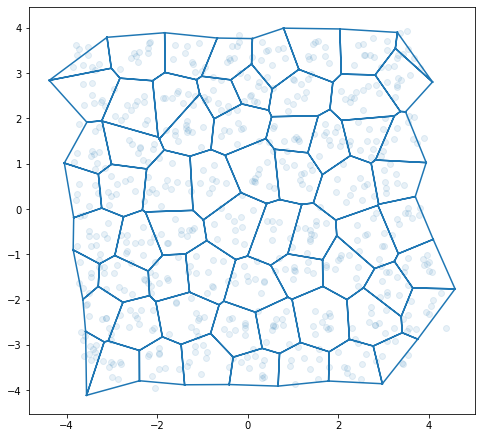

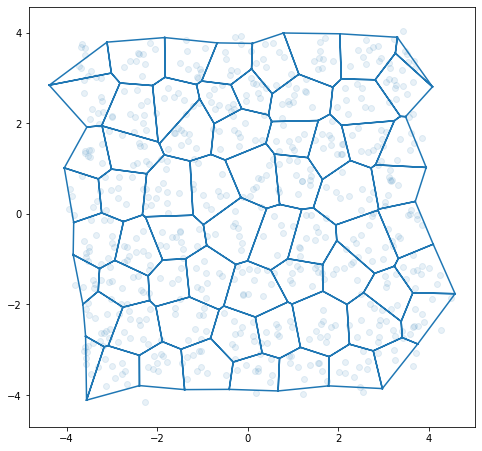

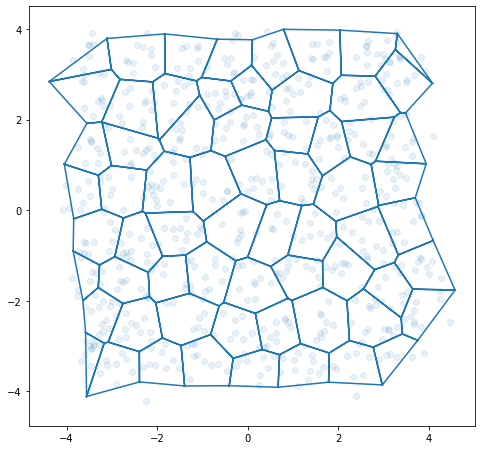

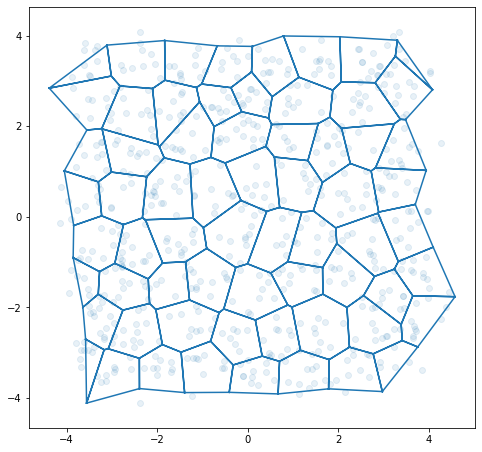

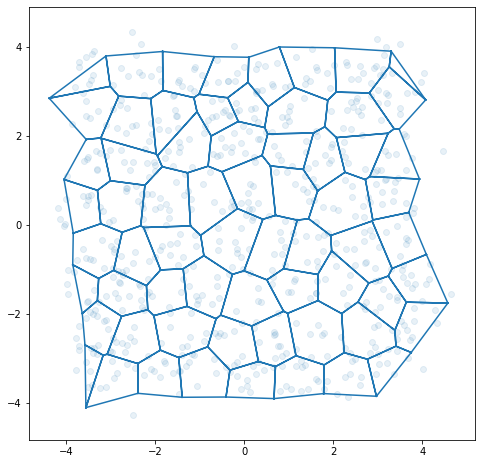

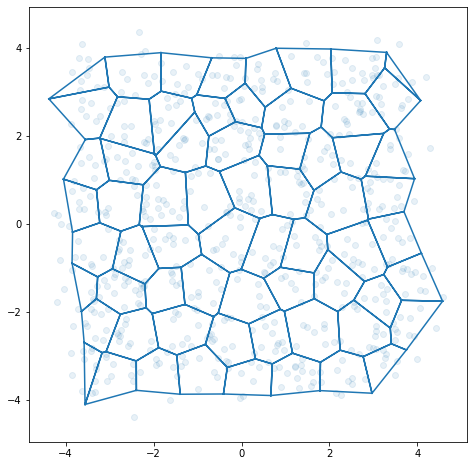

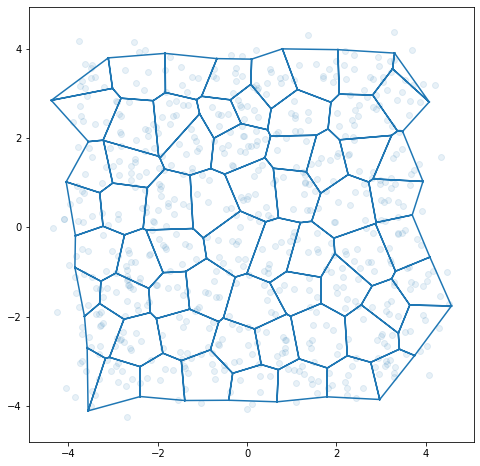

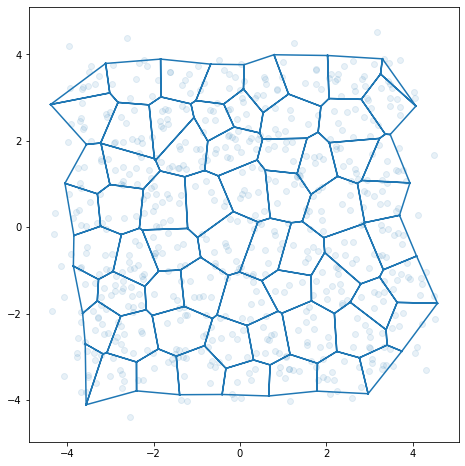

In [128]:
for i in range(10):
    sheetprot.diffusion()
    fig, ax = sheet_view(sheetprot.sheet, mode='quick',)
    ax.scatter(sheetprot.prot_df.x, sheetprot.prot_df.y, alpha = 0.1)
    fig.set_size_inches((8, 8))

# Starting the viscous solver

In [ ]:
# Initiate manager
manager = EventManager('face')

solver = EulerSolver(
    sheet,
    geom, 
    model,
    manager = manager,
    bounds = (-sheet.edge_df.length.median()/10,
        sheet.edge_df.length.median()/10)
    )

manager.update()
sheet.vert_df['viscosity'] = 0.1

In [ ]:
def save_sheet(history, path="", start_number = 0., dt = 0.1):
    times = history.time_stamps.shape[0]
    i = start_number
    for t in range(times):
        sheet = history.retrieve(t)
        hdf5.save_datasets(path+'../../test/movie_{:.2f}.hf5'.format(i), sheet)
        i+=dt
        

def run_sim(sim_save_dir, sheet, constriction, radial_tension, iteration=0):
    
    dirname = '{}_constriction_{}_radialtension{}'.format(
        constriction,radial_tension, iteration)
    dirname = os.path.join(sim_save_dir, dirname)
    
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    
    apoptosis_settings = {
        "critical_area": 5,
        "contract_rate": constriction,
        "basal_contract_rate": 1.01,
        "shrink_span": 2,
        "radial_tension": radial_tension,
        "max_traction":30,
        "current_traction":0,
        "geom": geom,
    }

    # Add some information to the sheet and copy initial sheet
    sheet2 = sheet.copy(deep_copy=True)
    sheet2.face_df['id'] = sheet2.face_df.index.values
    sheet2.settings['apoptosis'] = apoptosis_settings
    

    #sheet2 = apoptosis_process(dirname, solver, sheet2)
    
    # Initiate manager
    manager = EventManager('face')
    manager.append(basic_events.reconnect)
    
    # Starting viscous solver
    solver = EulerSolver(
    sheet2,
    geom, 
    model,
    manager = manager,
    bounds = (-sheet2.edge_df.length.median()/10,
        sheet2.edge_df.length.median()/10)
    )

    manager.update()
    sheet2.vert_df['viscosity'] = 0.1
    
    
    # Solving part... 
    # test in progress...
    dt = 0.1
    sheet2.settings["dt"] = dt
    
    # 1sec simulation with no action
    solver.solve(1-dt, dt)
    
    save_sheet(solver.history, start_number=0, dt=dt)
    
    # Add first wave of apoptotic cells
    apopto_cell = sheet2.face_df[sheet2.face_df.apoptosis == 1].id
    for c in apopto_cell : 
        apopto_kwargs = sheet2.settings['apoptosis'].copy()
        apopto_kwargs.update(
        {
            'face_id': c,
        }
        )
        manager.append(apoptosis, **apopto_kwargs)
    manager.update()
     
    # 10sec simulation with first wave of apoptosis
    solver.solve(10, dt)
    save_sheet(solver.history, start_number = 1, dt = 0.1)
    
    print(solver.history.time_stamps.shape)
    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    return sheet2, solver

In [ ]:
from datetime import datetime
global_start=datetime.now()
print ("start : " + str(global_start))
sheet= backupSheet2.copy()
sheet_out, solver_out=run_sim(sim_save_dir, sheet, 1.08, 50, 0)
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

In [ ]:
sheet_ = solver_out.history.retrieve(0)


In [ ]:
""""def apoptosis_process(dirname, solver, sheet):
    
    
    
    t = 0
    stop = 150
        
    # Run simulation
    while t < stop:
        if t%10 == 0:
            sheet.settings['lumen_prefered_vol'] *= 0.99        
        
        # Reset radial tension at each time step
        sheet.vert_df.radial_tension = 0
        
        # Add face in apoptosis according to the 
        # spatio-temporal patterning define previously
        if t == 1 :
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 1].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
        
        if t == 11 : 
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 2].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                    "max_traction":30,
                    "current_traction":0,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
                
        if t == 21:
            apopto_cell = sheet.face_df[sheet.face_df.apoptosis == 3].id
            for c in apopto_cell : 
                apopto_kwargs = sheet.settings['apoptosis'].copy()
                apopto_kwargs.update(
                {
                    'face_id': c,
                    "max_traction":30,
                    "current_traction":0,
                }
                )
                manager.append(apoptosis, **apopto_kwargs)
        
        manager.execute(sheet)
        
        res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})

        # add noise on vertex position to avoid local minimal.
        sheet.vert_df[
            ['x', 'y']] += np.random.normal(scale=1e-3, size=(sheet.Nv, 2))
        geom.update_all(sheet)
        
    
        
        # Save result in each time step.
        figname = os.path.join(
            dirname, 'invagination_{:04d}.png'.format(t))
        hdfname = figname[:-3] + 'hf5'
        
        
        with pd.HDFStore(hdfname) as test:
            test.put("settings", pd.Series(sheet.settings))

        with pd.HDFStore(hdfname) as store:
            settings = store['settings']
        
        hdf5.save_datasets(hdfname, sheet)



        manager.update()
        t += 1

    return sheet
"""

In [ ]:
# Sequential Execution

from datetime import datetime

global_start=datetime.now()
print ("start : " + str(global_start))

radial_tension = [50]
contractility_percent = [8]
contractility_rate = [1+c/100 for c in contractility_percent]

for c in contractility_rate:
    for rd in radial_tension:
        for iteration in range (0, 1):
            run_sim(sim_save_dir, sheet, c, rd, iteration)
        
        
        
global_end = datetime.now()
print ("end : " + str(global_end))
print ('Duree totale d execution : \n\t\t')
print (global_end-global_start)

In [ ]:
ipv.clear()
eptm = sheet2.copy()
geom.update_all(eptm)
fig, mesh = sheet_view(
    eptm,
    mode='3D',
    face={
        "visible":True,
        "color": eptm.face_df['area'],
    }
    
)
ipv.squarelim()
ipv.show()

In [ ]:
def custom_view(eptm, ax=None, coords=['z', 'x']):
    geom.update_all(eptm)
    eptm.face_df['lock'] = True
    specs = {
        "edge":
        {
            "visible" : False,
        },
        "vert" :
        {
            "visible": False
        },
        "face":
        {
            "visible":True,
            "color": eptm.face_df['area']*(1.0 - eptm.face_df['lock'].astype(float)),
            "color_range": (
                eptm.face_df['area'].quantile(0.1),
                eptm.face_df['area'].quantile(0.9)
                )
        }      
    }
    eptm.face_df["visible"] = eptm.face_df.y > -0.1
    fig, ax = sheet_view(eptm, coords=coords, mode="2D", ax=ax, **specs)
    ax.set_xlim(-10, 10)
    fig.set_size_inches(12, 4)
    return fig, ax

In [ ]:
create_gif(
    solver.history,
    "../data/tube.gif",
    num_frames=200,
    margin=2,
    coords=['z', 'x'],
    draw_func=custom_view)

In [ ]:
solver.history